### UNSEEN CANARI ###

CANARI HIST2 consists of a large ensemble of historical HadGEM3-GC31 runs between 1950-2014, with 40 members. The following variables are available:

* Daily temperature (for demand conversion)
* Hourly (!) 10m wind speed (for wind power conversion)

The temperature -> demand conversion is relatively simple. Convert to HDD/CDD and then use the regression relationships.

The 10m wind speed to wind power generation is more involved. Convert 10m wind speed to 100m wind speed through a power law conversion.

First we want to track down the daily temperature data for processing. To see whether we get similar answers using DePreSys for demand.

In [1]:
# Local imports
import os
import re
import sys
import glob

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import iris

# Specific imports
from tqdm import tqdm
from iris.util import equalise_attributes

# Load my specific functions
sys.path.append("/home/users/benhutch/unseen_functions")
from functions import create_masked_matrix

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
# Set up the base canari dir
base_canari_dir = "/gws/nopw/j04/canari/shared/large-ensemble/priority/"

# /gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/3/ATM/yearly/1960/

period = "HIST2"
ensemble = "3"
domain = "ATM"
sample_year = "1960"
var_name = "m01s03i236_7"

# set up the years
years = np.arange(1950, 2014 + 1)

# sample fnam
sample_fnam = "cy537a_13_day__195407-195407.nc"

sample_fpath = "/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/3/ATM/yearly/1960/cw345a_3_day_m01s03i236_7.nc"

# Base directory for csv files
base_csv_dir = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs/"

In [3]:
# set up the empty dataframe
model_df_full = pd.DataFrame()

# Check that there are csv files for all of the years
# loop ovber the years
for year in tqdm(years):
    # create the fpath
    fpath = os.path.join(base_csv_dir, f"canari-le-tas-United_Kingdom-{year}-{period}.csv")
    # check if the file exists
    if not os.path.exists(fpath):
        print(f"Missing file for {year}")
        sys.exit()

    # Load the dataframe
    model_df_this = pd.read_csv(fpath)

    # concatenate the dataframes
    model_df_full = pd.concat([model_df_full, model_df_this], ignore_index=True)

100%|██████████| 65/65 [00:02<00:00, 24.84it/s]


In [6]:
model_df_full.tail()

,member,time,tas
935995,40,2014-12-26 12:00:00,276.647215
935996,40,2014-12-27 12:00:00,274.838709
935997,40,2014-12-28 12:00:00,275.233602
935998,40,2014-12-29 12:00:00,275.932057
935999,40,2014-12-30 12:00:00,275.815959


(array([1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.0000e+00, 4.0000e+00, 3.0000e+00,
        7.0000e+00, 6.0000e+00, 1.1000e+01, 1.5000e+01, 2.4000e+01,
        2.9000e+01, 4.0000e+01, 6.2000e+01, 8.5000e+01, 1.2900e+02,
        1.7300e+02, 2.4000e+02, 3.8000e+02, 4.9300e+02, 6.0300e+02,
        7.8900e+02, 1.1740e+03, 1.3970e+03, 1.9020e+03, 2.3750e+03,
        3.0510e+03, 3.9310e+03, 4.8890e+03, 5.9330e+03, 6.9840e+03,
        8.2460e+03, 9.3710e+03, 1.0642e+04, 1.1711e+04, 1.2683e+04,
        1.3911e+04, 1.4991e+04, 1.6146e+04, 1.7709e+04, 1.9094e+04,
        2.0733e+04, 2.2339e+04, 2.4106e+04, 2.5558e+04, 2.6637e+04,
        2.7747e+04, 2.8724e+04, 2.8510e+04, 2.8438e+04, 2.8871e+04,
        2.7867e+04, 2.6644e+04, 2.5468e+04, 2.3965e+04, 2.2717e+04,
        2.1609e+04, 2.1206e+04, 2.1102e+04, 2.1275e+04, 2.2044e+04,
        2.2514e+04, 2.3068e+04, 2.3617e+04, 2.4094e+04, 2.4226e+04,
        2.3675e+04, 2.2217e+04, 2.0581e+04, 1.84

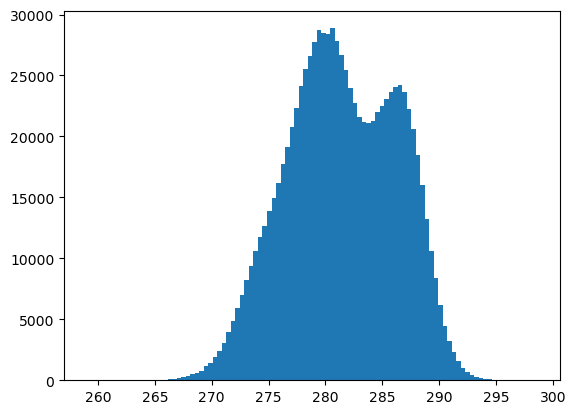

In [7]:
# plot a distribution of the temperature data (tas column)
plt.hist(model_df_full["tas"], bins=100)

In [4]:
# load in the csv for the first year
df_first = pd.read_csv(os.path.join(base_csv_dir, f"canari-le-tas-United_Kingdom-{years[0]}-{period}.csv"))

# load in the csv for the second year
df_second = pd.read_csv(os.path.join(base_csv_dir, f"canari-le-tas-United_Kingdom-{years[1]}-{period}.csv"))

In [5]:
df_first.tail()

,member,time,tas
14395,40,1950-12-26 12:00:00,278.907086
14396,40,1950-12-27 12:00:00,278.390693
14397,40,1950-12-28 12:00:00,279.895779
14398,40,1950-12-29 12:00:00,281.720537
14399,40,1950-12-30 12:00:00,281.228761


In [6]:
df_second.tail()

,member,time,tas
14395,40,1951-12-26 12:00:00,277.080085
14396,40,1951-12-27 12:00:00,277.112254
14397,40,1951-12-28 12:00:00,277.060156
14398,40,1951-12-29 12:00:00,276.488597
14399,40,1951-12-30 12:00:00,279.202145


In [7]:
# join the two dataframes
df_merged = pd.concat([df_first, df_second], ignore_index=True)

In [9]:
df_merged.tail()

,member,time,tas
28795,40,1951-12-26 12:00:00,277.080085
28796,40,1951-12-27 12:00:00,277.112254
28797,40,1951-12-28 12:00:00,277.060156
28798,40,1951-12-29 12:00:00,276.488597
28799,40,1951-12-30 12:00:00,279.202145


In [3]:
# load in the sample file
sample_cube = iris.load_cube(sample_fpath)

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/fileformats/cf.py:880: IrisCfMissingVarWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'm01s03i236_7'
  warnings.warn(


In [4]:
sample_cube.var_name

'm01s03i236_7'

In [5]:
# Function for adding realization metadata
# for r1i1p1f1, r2i1p1f1, etc.
def realization_metadata(cube, field, fpath):
    """Modify the cube's metadata to add a "realization" coordinate.

    A function which modifies the cube's metadata to add a "realization"
    (ensemble member) coordinate from the filename if one doesn't already exist
    in the cube.

    """
    # Add an ensemble member coordinate if one doesn't already exist.
    if not cube.coords("realization"):
        # The ensemble member is encoded in the filename as *_???.pp where ???
        # is the ensemble member.

        # # Regular expression pattern for the desired format
        # pattern = re.compile(r"(r\d+i\d+p\d+f\d+)")

        # Split the fpath by /
        fpath_split = fpath.split("/")

        # extract the member as the 9th element
        realization_number = fpath_split[9]

        # print the realization number
        print(realization_number)

        realization_coord = iris.coords.AuxCoord(
            np.int32(realization_number), "realization", units="1"
        )

        cube.add_aux_coord(realization_coord)

    return cube

In [6]:
# set up 10 files for the same year
members = np.arange(1, 6)

file_list = []

# test years
test_years = [1960, 1961]

# loop over the years
for year in test_years:
    year_list = []
    for member in members:
        # set up the file path
        fpath = os.path.join(
            base_canari_dir, period, str(member), domain, "yearly", str(year), f"*day_{var_name}.nc"
        )

        # glob the file path to check if it exists
        files = glob.glob(fpath)

        # if the file exists
        if len(files) == 1:
            # append the file to the list
            year_list.append(files[0])
        elif len(files) == 0:
            raise ValueError(f"No files found for {fpath}")
        else:
            raise ValueError(f"Multiple files found for {fpath}")

    # append the year list to the file list
    file_list.append(year_list)

In [7]:
file_list

[['/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/1/ATM/yearly/1960/cv575a_1_day_m01s03i236_7.nc',
  '/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/2/ATM/yearly/1960/cv625a_2_day_m01s03i236_7.nc',
  '/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/3/ATM/yearly/1960/cw345a_3_day_m01s03i236_7.nc',
  '/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/4/ATM/yearly/1960/cw356a_4_day_m01s03i236_7.nc',
  '/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/5/ATM/yearly/1960/cv827a_5_day_m01s03i236_7.nc'],
 ['/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/1/ATM/yearly/1961/cv575a_1_day_m01s03i236_7.nc',
  '/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/2/ATM/yearly/1961/cv625a_2_day_m01s03i236_7.nc',
  '/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/3/ATM/yearly/1961/cw345a_3_day_m01s03i236_7.nc',
  '/gws/nopw/j04/canari/shared/large-ensemble/priority/HIST2/4/ATM/yearly/1961/cw356a_4_day_m01s03i236_7.nc',
  '/gws/n

In [8]:
# test loading the first file from the list
cube = iris.load_cube(file_list[-1])

In [9]:
# set up the constraint
constraint = iris.Constraint(
    var_name,
    realization=lambda value: True,
)

# set up a list to store the cubes
cubes = []

for list in file_list:
    # load in the cubes
    cubes_year_this = iris.load(
        list,
        constraint,
        callback=realization_metadata,
    )

    # append the cubes to the list
    cubes.append(cubes_year_this)

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/fileformats/cf.py:880: IrisCfMissingVarWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'm01s03i236_7'
  warnings.warn(


1
2
3
4
5
1
2
3
4
5


In [11]:
# list of cube
cubes_list = []

for cube in cubes:
    # equalise the attributes
    removed_attrs = equalise_attributes(cube)

    # merge the cube
    model_cube_this = cube.merge_cube()

    # append the cube to the list
    cubes_list.append(model_cube_this)

In [15]:
# convert cubes_list to a cube list
cubes = iris.cube.CubeList(cubes_list)

In [16]:
cubes

[<iris 'Cube' of air_temperature / (K) (realization: 5; time: 360; latitude: 324; longitude: 432)>,
<iris 'Cube' of air_temperature / (K) (realization: 5; time: 360; latitude: 324; longitude: 432)>]

In [17]:
model_cube = cubes.concatenate_cube()

In [19]:
model_cube.shape

(5, 720, 324, 432)

In [20]:
# Make sure cube is on the correct grid system 
model_cube = model_cube.intersection(longitude=(-180, 180))

In [21]:
%%time

# set up the mask matrix
MASK_MATRIX = create_masked_matrix(
    country="United Kingdom",
    cube=model_cube,
)

model_data = model_cube.data

# Apply the mask to the model cube
model_values = model_data * MASK_MATRIX

# Where there are zeros in the mask we want to set these to Nans
model_values_masked = np.where(MASK_MATRIX == 0, np.nan, model_values)

Found Country United Kingdom
CPU times: user 6.88 s, sys: 9.72 s, total: 16.6 s
Wall time: 55.3 s


In [22]:
model_values_masked.shape

(5, 720, 324, 432)

In [23]:
%%time

# Take the Nanmean of the data
model_values = np.nanmean(model_values_masked, axis=(2, 3))

CPU times: user 1.2 s, sys: 357 ms, total: 1.56 s
Wall time: 1.6 s


In [24]:
model_values.shape

(5, 720)

In [25]:
model_df = pd.DataFrame()

# Extract the ini years, member and lead times
realizations = model_cube.coord("realization").points
model_times = model_cube.coord("time").points

# loop through the inits, members and leadtimes
for r, realization in enumerate(realizations):
    # get the model data this
    model_data = model_values[r, :]

    # set up the dataframe
    df_this = pd.DataFrame(
        {
            "member": realization,
            "time": model_times,
            "UK_mean_T2m": model_data,
        }
    )

    # Add the dataframe to the model_df
    model_df = pd.concat([model_df, df_this])

In [26]:
model_df.tail()

,member,time,UK_mean_T2m
715,5,372859200.0,277.997269
716,5,372945600.0,277.060428
717,5,373032000.0,277.460376
718,5,373118400.0,279.642029
719,5,373204800.0,278.322185


In [27]:
import pandas as pd
import cftime

# Define a function to convert 360-day calendar time to datetime
def convert_360_day_calendar(time_value):
    return cftime.num2date(time_value, units="seconds since 1950-01-01 00:00:00", calendar="360_day")

# Apply the conversion function to the 'time' column
model_df["time"] = model_df["time"].apply(convert_360_day_calendar)

# model_df.tail()

# Convert cftime objects to pandas datetime objects
# model_df["time"] = pd.to_datetime(model_df["time"].astype(str), format="%Y-%m-%d %H:%M:%S")

In [28]:
model_df.tail()

,member,time,UK_mean_T2m
715,5,1961-12-26 12:00:00,277.997269
716,5,1961-12-27 12:00:00,277.060428
717,5,1961-12-28 12:00:00,277.460376
718,5,1961-12-29 12:00:00,279.642029
719,5,1961-12-30 12:00:00,278.322185


(array([ 1.,  0.,  2.,  1.,  2.,  2.,  1.,  3.,  3.,  2.,  5.,  4.,  3.,
         7., 10.,  9.,  6., 12.,  8., 17., 18., 25., 26., 21., 21., 20.,
        15., 33., 24., 34., 30., 38., 40., 42., 45., 40., 53., 52., 44.,
        62., 48., 49., 59., 49., 62., 62., 70., 65., 57., 61., 61., 55.,
        63., 66., 51., 75., 72., 79., 81., 55., 66., 65., 42., 63., 61.,
        64., 46., 68., 59., 52., 51., 50., 51., 55., 43., 59., 51., 48.,
        65., 52., 72., 60., 52., 43., 36., 28., 32., 24., 19., 16., 12.,
        19.,  9., 13.,  8.,  6.,  6.,  5.,  4.,  4.]),
 array([266.10519095, 266.36810463, 266.63101831, 266.89393199,
        267.15684567, 267.41975935, 267.68267303, 267.9455867 ,
        268.20850038, 268.47141406, 268.73432774, 268.99724142,
        269.2601551 , 269.52306878, 269.78598246, 270.04889614,
        270.31180982, 270.5747235 , 270.83763718, 271.10055086,
        271.36346453, 271.62637821, 271.88929189, 272.15220557,
        272.41511925, 272.67803293, 272.94094661, 

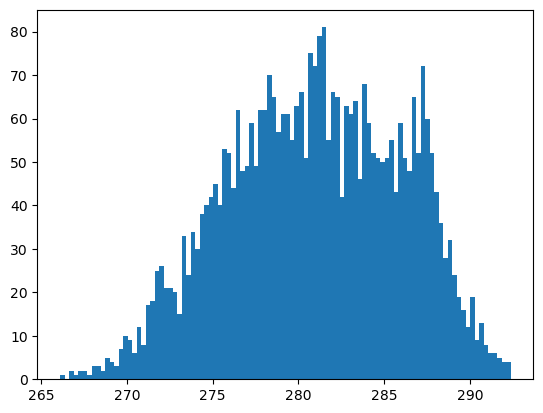

In [29]:
# plot a histogram of the data
plt.hist(model_df["UK_mean_T2m"], bins=100)

In [35]:
fpath = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs/canari-le-tas-United_Kingdom-1950-HIST2.csv"


# /gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs/

# import as a csv files
df = pd.read_csv(fpath)

In [38]:
df.tail()

,member,time,tas
14395,40,1950-12-26 12:00:00,278.907086
14396,40,1950-12-27 12:00:00,278.390693
14397,40,1950-12-28 12:00:00,279.895779
14398,40,1950-12-29 12:00:00,281.720537
14399,40,1950-12-30 12:00:00,281.228761
